In [1]:
import torch
import math
import numpy as np
from collections import OrderedDict
from smt.sampling_methods import LHS
import matplotlib.pyplot as plt
import plotly.graph_objects as go

ModuleNotFoundError: No module named 'plotly'

In [ ]:
if torch.cuda.is_available():    
    device = torch.device('cuda:0')    
else:
    device = torch.device('cpu')

print(device)

cuda:0


In [ ]:
class DNNModel(torch.nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size,
        output_size,
        depth,
        act=torch.nn.Tanh,        
    ):
        super(DNNModel, self).__init__()
        
        layers = [('input', torch.nn.Linear(input_size, hidden_size))]
        layers.append(('input_activation', act()))
        for i in range(depth): 
            layers.append(
                ('hidden_%d' % i, torch.nn.Linear(hidden_size, hidden_size))
            )
            layers.append(('activation_%d' % i, act()))
        layers.append(('output', torch.nn.Linear(hidden_size, output_size)))

        layerDict = OrderedDict(layers)
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out

In [ ]:
class PINN():
    def __init__(self):
        
        self.model = DNNModel(
            input_size=2,
            hidden_size=50,
            output_size=8,
            depth=5,
            act=torch.nn.Tanh,            
        ).to(device)


In [ ]:
pinn_model=torch.load('./channel_lhs_8l_0.1m_0.001_0.0001.t7')

model = pinn_model.model
model.eval()

DNNModel(
  (layers): Sequential(
    (input): Linear(in_features=2, out_features=50, bias=True)
    (input_activation): Tanh()
    (hidden_0): Linear(in_features=50, out_features=50, bias=True)
    (activation_0): Tanh()
    (hidden_1): Linear(in_features=50, out_features=50, bias=True)
    (activation_1): Tanh()
    (hidden_2): Linear(in_features=50, out_features=50, bias=True)
    (activation_2): Tanh()
    (hidden_3): Linear(in_features=50, out_features=50, bias=True)
    (activation_3): Tanh()
    (hidden_4): Linear(in_features=50, out_features=50, bias=True)
    (activation_4): Tanh()
    (hidden_5): Linear(in_features=50, out_features=50, bias=True)
    (activation_5): Tanh()
    (hidden_6): Linear(in_features=50, out_features=50, bias=True)
    (activation_6): Tanh()
    (hidden_7): Linear(in_features=50, out_features=50, bias=True)
    (activation_7): Tanh()
    (output): Linear(in_features=50, out_features=5, bias=True)
  )
)

In [ ]:
x = torch.arange(0, 5 + 0.01 , 0.01)
y = torch.arange(0, 1 +0.01, 0.01)

outlet= torch.stack(torch.meshgrid(x[-1], y)).reshape(2, -1).T
outlet = outlet.to(device)
outlet.requires_grad = True

y_out = model(outlet)
dpsi_dX = torch.autograd.grad(inputs=outlet, outputs=y_out[:,0], grad_outputs=torch.ones_like(y_out[:,0]), retain_graph=True, create_graph=True)[0]
dpsi_dx = -1*dpsi_dX[:, 0] 
dpsi_dy = dpsi_dX[:, 1]    

out=torch.cat([outlet, dpsi_dX ,y_out], 1)
out=out.detach().cpu().numpy()
np.savetxt('outlet.txt', out)

channel= torch.stack(torch.meshgrid(x, y)).reshape(2, -1).T
channel = channel.to(device)
channel.requires_grad = True

y_pred = model(channel)
dpsi_dX = torch.autograd.grad(inputs=channel, outputs=y_pred[:,0], grad_outputs=torch.ones_like(y_pred[:,0]), retain_graph=True, create_graph=True)[0]
dpsi_dx = -1*dpsi_dX[:, 0] 
dpsi_dy = dpsi_dX[:, 1]    

fld=torch.cat([channel, dpsi_dX ,y_pred], 1)
fld=fld.detach().cpu().numpy()
np.savetxt('channel.txt', fld)

c:\Python\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
# Creating 2-D grid
fx = np.arange(0, 5+0.05, 0.05)
fy = np.arange(0, 1+0.01, 0.01)
[X, Y] = np.meshgrid(fx, fy)

Z = np.array(fld[:,3]).reshape(-1,101)
print (Z.shape)
#print (Z)
fig = go.Figure(data =
     go.Contour(x = fy,
                y = fx, z = Z,               
            contours=dict(
                start=0.1,
                end=1.35,
                size=0.15)
               )
               )
 
fig.show()

(501, 101)


In [ ]:
U=np.loadtxt('Fld-CFD.dat')

cx = np.linspace(0, 1, 51)
cy = np.linspace(0, 5, 101)

Z = np.array(U[:,2]).reshape(-1,51)

fig = go.Figure(data =
     go.Contour(x = cy,
                y = cx, z = Z,               
            
               )
               )
 
fig.show()

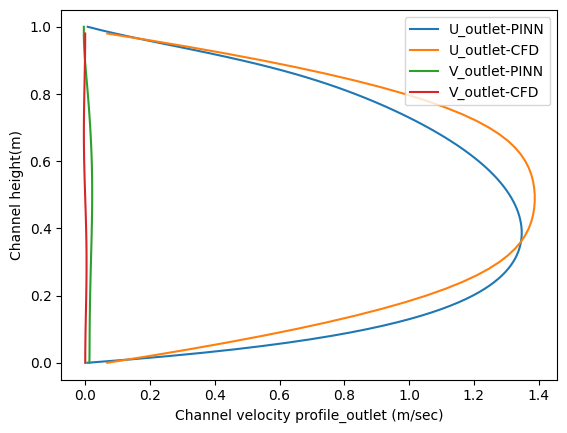

In [ ]:
U=np.loadtxt('U-CFD.dat')

plt.plot(np.array(fld[-101:,3]).reshape(101,-1),fy, label="U_outlet-PINN")
plt.plot(U[:,1].reshape(50,-1),U[:,0].reshape(50,-1),label="U_outlet-CFD")
plt.plot(np.array(fld[-101:,2]).reshape(101,-1),fy, label="V_outlet-PINN")
plt.plot(U[:,2].reshape(50,-1),U[:,0].reshape(50,-1), label="V_outlet-CFD")
plt.legend(loc=1)
plt.xlabel("Channel velocity profile_outlet (m/sec)")
plt.ylabel("Channel height(m)")
plt.show()

In [ ]:
x = torch.arange(0, 5, 0.05)
y = torch.arange(0, 1, 0.02)

outlet= torch.stack(torch.meshgrid(x[-1], y)).reshape(2, -1).T
outlet = outlet.to(device)
outlet.requires_grad = True

y_out = model(outlet)
dpsi_dX = torch.autograd.grad(inputs=outlet, outputs=y_out[:,0], grad_outputs=torch.ones_like(y_out[:,0]), retain_graph=True, create_graph=True)[0]
dpsi_dX[:, 0] = -1*dpsi_dX[:, 0]  

out=torch.cat([outlet, dpsi_dX ,y_out], 1)
out=out.detach().cpu().numpy()

umse = np.square(np.subtract(U[:,1],out[:,3])).mean() 
vmse = np.square(np.subtract(U[:,2],out[:,2])).mean()

urms = math.sqrt(umse)
vrms = math.sqrt(vmse)

print("U_rms=", urms,"V_rms=", vrms)

U_rms= 0.12633185691206833 V_rms= 0.015652727391003634
